**Referenced https://en.wikipedia.org/wiki/LeNet for LeNet Architecture**

# CNN on MNIST Digits Low Res

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import stats

In [13]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Print dimensions of the original images
print("Original Train Images Shape:", train_images.shape)
print("Original Test Images Shape:", test_images.shape)

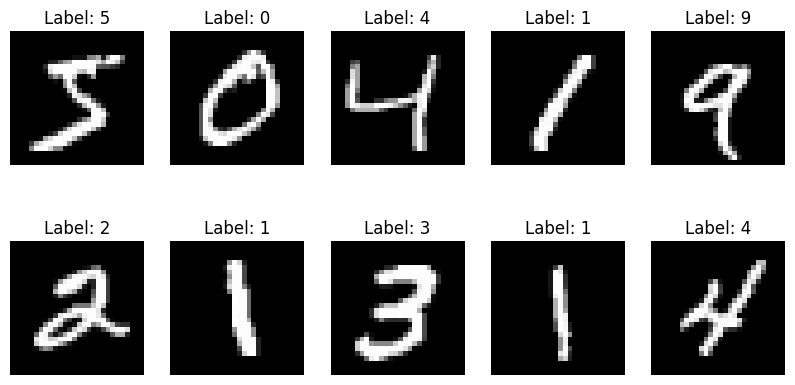

In [15]:
# Display some original images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

## I'm using MAX pooling instead of average pooling because
- **I found that average pooling made the images too blurry**
- **MAX pooling retains the edges which is important for digit recognition**

In [16]:
# Reshape images to 4D tensors (height, width, channels)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Define the pooling layer
pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='valid')

# Apply max pooling to the images
train_images_pooled = pooling_layer(train_images)
test_images_pooled = pooling_layer(test_images)

# Normalize pixel values to be between 0 and 1
train_images_pooled = train_images_pooled / 255.0
test_images_pooled = test_images_pooled / 255.0

print("Pooled Train Images Shape:", train_images_pooled.shape)

train_images = train_images_pooled
test_images = test_images_pooled

Pooled Train Images Shape: (60000, 7, 7, 1)


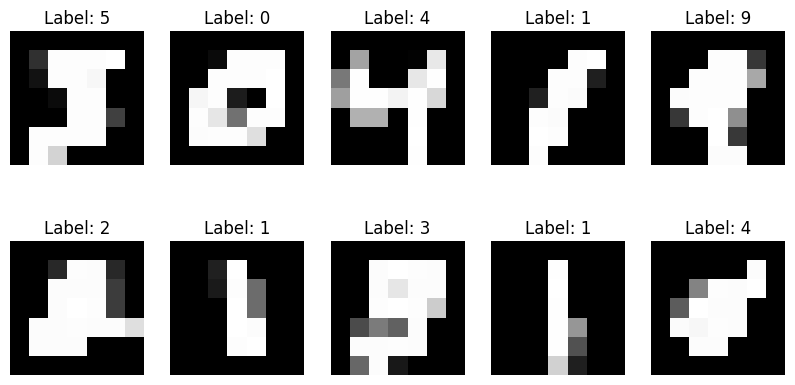

In [18]:
# Display some original images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images_pooled[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

## Here I defined the CNN model with reference to LeNet architecture
- **The model has two convolutional layers followed by max pooling layers**
- **The output of the second pooling layer is flattened and passed through two dense layers**
- **The final dense layer has 10 units with softmax activation**

**Reason I chose to implement LeNet architecture is because it is a simple and effective architecture for image classification**
**It has been used for MNIST dataset and has shown good performance**

In [20]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(7, 7, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


/Users/alanzhang/Library/Python/3.10/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


**I chose to use the Adam optimizer because it is computationally efficient and popular for CNNs**


In [21]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**I chose to use 10 epochs because I found that the model converges to a good accuracy within 10 epochs**

**With more time, I would have trained for more epochs**

In [30]:
epochs = 10
# Train the model
history = model.fit(train_images, train_labels, epochs, validation_data=(test_images, test_labels), verbose=2)
train_acc = history.history['accuracy']
print("Train accuracy:", train_acc)

6000/6000 - 14s - 2ms/step - accuracy: 0.8963 - loss: 0.3102 - val_accuracy: 0.8956 - val_loss: 0.3239
Train accuracy: [0.8962666392326355]


In [23]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 91.26%


In [26]:


def get_margin_of_error(test_acc, accuracy_results, n_iterations):
    # Compute confidence intervals
    p_value = (np.sum(np.array(accuracy_results) >= test_acc) + 1) / (n_iterations + 1)

    print("p-value:", p_value)

    alpha = 0.05
    z_score = stats.norm.ppf(1 - alpha / 2)

    # Compute the standard error of the permutation test accuracies
    std_error = np.std(accuracy_results) / np.sqrt(n_iterations)

    # Compute the margin of error
    margin_of_error = z_score * std_error

    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = test_acc - margin_of_error
    upper_bound = test_acc + margin_of_error

    print("p-value:", p_value)
    print("95% Confidence Interval:", (lower_bound, upper_bound))
    return margin_of_error

In [27]:
# Permutation test
n_iterations = 100
permutation_test_accuracies = []

for i in range(n_iterations):
    print(f'Iteration: {i+1}')

    indices = np.random.choice(train_images.shape[0], size=100, replace=True)
    indices_tensor = tf.convert_to_tensor(indices)  # Convert numpy array to tensor
    resampled_images = tf.gather(train_images, indices_tensor)
    resampled_labels = tf.gather(train_labels, indices_tensor)

    permuted_train_labels = np.random.permutation(resampled_labels)
    
    model.fit(resampled_images, permuted_train_labels, epochs=10, verbose=0)
    
    # Evaluate model on test data
    _, acc = model.evaluate(test_images, test_labels, verbose=0)
    permutation_test_accuracies.append(acc)  # Append accuracy value to the list
    print(f'Accuracy: {acc*100:.2f}%')



train_margin_of_error = get_margin_of_error(train_acc, permutation_test_accuracies, n_iterations)

test_margin_of_error = get_margin_of_error(test_acc, permutation_test_accuracies, n_iterations)


Iteration: 1
Accuracy: 18.31%
Iteration: 2
Accuracy: 23.23%
Iteration: 3
Accuracy: 20.72%
Iteration: 4
Accuracy: 22.62%
Iteration: 5
Accuracy: 20.29%
Iteration: 6
Accuracy: 14.45%
Iteration: 7
Accuracy: 14.72%
Iteration: 8
Accuracy: 11.58%
Iteration: 9
Accuracy: 11.75%
Iteration: 10
Accuracy: 9.48%
p-value: 0.09090909090909091
p-value: 0.09090909090909091
95% Confidence Interval: (array([0.7808529 , 0.8544529 , 0.86401956, 0.87015288, 0.8767529 ,
       0.8782029 , 0.88126956, 0.88340287, 0.88691955, 0.88751959]), array([0.8391471 , 0.9127471 , 0.92231376, 0.92844708, 0.9350471 ,
       0.9364971 , 0.93956376, 0.94169707, 0.94521375, 0.94581379]))
p-value: 0.09090909090909091
p-value: 0.09090909090909091
95% Confidence Interval: (0.883452881347135, 0.9417470803151575)


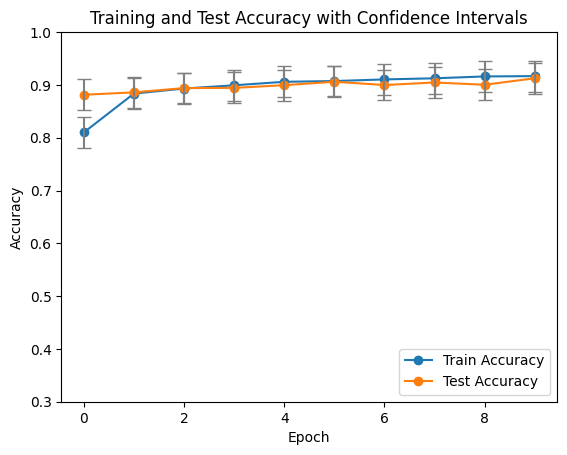

In [28]:
# Plot training and test accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

# Plot confidence intervals
for epoch, (train_acc, test_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
    plt.errorbar(epoch, train_acc, yerr=train_margin_of_error, fmt='none', ecolor='gray', capsize=5)
    plt.errorbar(epoch, test_acc, yerr=test_margin_of_error, fmt='none', ecolor='gray', capsize=5)

plt.title('Training and Test Accuracy with Confidence Intervals')
plt.show()


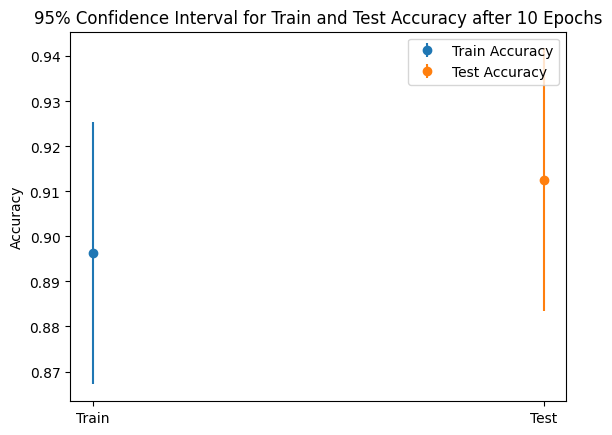

In [32]:
plt.title('95% Confidence Interval for Train and Test Accuracy after ' + str(epochs) + ' Epochs')
# plot both train and test confidence intervals
plt.errorbar(x=0, y=train_acc, yerr=train_margin_of_error, fmt='o', label='Train Accuracy')
plt.errorbar(x=1, y=test_acc, yerr=test_margin_of_error, fmt='o', label='Test Accuracy')
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('Accuracy')
plt.legend()

plt.show()